<a href="https://colab.research.google.com/github/UznetDev/NT-M5-H1-Smoking-Cmpetition/blob/main/notebooks/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Body


*In this notebook, a model has been created to predict smoking using the sklearn library.*

## Import

In [ ]:
!pip install optuna

In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
from plotly import graph_objs as go
import seaborn as sns
import optuna
from joblib import dump
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import (LogisticRegression,
                                  RidgeClassifier,
                                  SGDClassifier,
                                  Perceptron,
                                  PassiveAggressiveClassifier)
from sklearn.naive_bayes import (GaussianNB,
                                 MultinomialNB,
                                 BernoulliNB,
                                 ComplementNB)
from sklearn.svm import (SVC,
                         LinearSVC,
                         NuSVC)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              StackingClassifier)
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis,
                                           QuadraticDiscriminantAnalysis)
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold

## include data

In [ ]:
train_df = pd.read_csv('data/train.csv').drop(columns=['id'], axis=1)
test_df = pd.read_csv('data/test.csv')
train_df.head(1)

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,55.0,170.0,80.0,92.0,1.2,0.8,1.0,1.0,129.0,74.0,...,49.0,114.0,15.4,1.0,0.9,20.0,23.0,13.0,0.0,0.0


## Functions

Necessary functions

In [ ]:
def get_WoE(data, feature_name, target_name, sort=False):
    df = data.copy()
    df = df.groupby(feature_name)[target_name].value_counts().unstack().rename(columns={1: '# of events', 0: '# of non-events'})
    df['Percentage events'] = df['# of events'] / df['# of events'].sum()
    df['Percentage non-events'] = df['# of non-events'] / df['# of non-events'].sum()
    df['WOE'] = np.log(df['Percentage events'] / df['Percentage non-events'])

    df['Total Observations'] = df['# of events'] + df['# of non-events']
    df['Percent of Observations'] = (df['Total Observations'] / \
                                            df['Total Observations'].sum() * 100).round(3)
    df['rank'] = df['WOE'].rank()
    if sort:
        df = df.sort_values('WOE')
    return df.reset_index()



def view_WoE(woe_df: pd.DataFrame, cat, plotly=True) -> go.Figure:
    if isinstance(woe_df, pd.DataFrame):
      if plotly:
          x = woe_df.index.astype(str)
          fig = go.Figure()
          fig.add_trace(go.Bar(
              x=x,
              y=woe_df['WOE'],
              name='WOE',
              yaxis='y1'
          ))

          fig.add_trace(go.Scatter(
              x=x,
              y=woe_df['WOE'],
              name='Weight of Evidence',
              mode='lines+markers',
              marker=dict(color='red'),
              yaxis='y1'
          ))

          fig.add_trace(go.Scatter(
              x=x,
              y=woe_df['rank'],
              name='Percent of Observations',
              mode='lines+markers',
              marker=dict(color='green'),
              yaxis='y2'
          ))
          fig.update_layout(
              yaxis=dict(
                  title="WOE",
                  showgrid=False
              ),
              yaxis2=dict(
                  title="Percent of Observations",
                  overlaying='y',
                  side='right',
                  showgrid=False
              ),
              xaxis=dict(
                  title="Category"
              ),
              title="WOE and Rank Graphs"
          )

          return fig
      else:
          fig, ax1 = plt.subplots(figsize=(10, 6))
          ax2 = ax1.twinx()

          sns.pointplot(data=woe_df, x=cat, y='WOE', color='red', linewidth=2, ax=ax1)
          ax1.set_ylabel('Weight of Evidence (WoE)', color='red')
          ax1.tick_params(axis='y', colors='red')
          ax1.set_xlabel('Categories')
          for label in ax1.get_xticklabels():
              label.set_rotation(90)
          sns.barplot(data=woe_df, x=cat, y='Percent of Observations', alpha=0.3, ax=ax2)
          ax2.set_ylabel('Rate of Observations')
          ax2.set_ylim(0, woe_df['Percent of Observations'].max() * 1.2)
          ax2.axhline(y=5, color='red', linestyle='--', linewidth=1.5)
          ax1.grid(visible=True, which='major', linestyle='--')
          plt.title("WoE change plot")
          plt.show()
    else:
        return woe_df


def plot_histograms(train_df, test_df, cat, rank, rotation=40):
    fig, ax = plt.subplots(figsize=(10, 10), nrows=2, ncols=2)

    sns.histplot(data=train_df[rank].astype(str), kde=True, ax=ax[0][0])
    ax[0][0].set_title(f'{rank} in Train')
    sns.histplot(data=train_df[cat].astype(str), kde=True, ax=ax[0][1])
    ax[0][1].set_title(f'{cat} in Train')

    sns.histplot(data=test_df[rank].astype(str), kde=True, ax=ax[1][0])
    ax[1][0].set_title(f'{rank} in Test')
    sns.histplot(data=test_df[cat].astype(str), kde=True, ax=ax[1][1])
    ax[1][1].set_title(f'{cat} in Test')

    for axes in ax.flat:
        axes.set_xticklabels(axes.get_xticklabels(), rotation=rotation)

    plt.tight_layout()
    plt.show()

def cut_on_bin(data, column, bins):
  return pd.cut(train_df[column], bins=bins, duplicates='drop')

def set_woe(woe_df, data, column):
  rank = woe_df.set_index(column)['rank'].to_dict()
  woe = woe_df.set_index(column)['WOE'].to_dict()
  return data[column].map(rank), data[column].map(woe)

## view data

In [ ]:
train_df.columns

Index(['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic',
       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST',
       'ALT', 'Gtp', 'dental caries', 'smoking'],
      dtype='object')

In [ ]:
train_df.shape

(15000, 23)

In [ ]:
train_df.describe()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.00000,15000.000000,15000.000000,...,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,42.659667,164.669333,64.235333,80.251100,1.034373,1.029453,1.005600,1.00600,119.219133,74.963667,...,57.374733,113.391200,14.505213,1.016067,0.866873,22.236600,20.859400,26.289933,0.145733,0.369133
std,10.514524,8.524211,10.999092,7.927326,0.304866,0.302373,0.074626,0.07723,11.151900,7.956559,...,11.436670,18.574279,1.398364,0.160656,0.165501,5.640184,10.310916,18.685708,0.352850,0.482586
min,20.000000,140.000000,40.000000,1.000000,0.100000,0.100000,1.000000,1.00000,84.000000,42.000000,...,28.000000,47.000000,7.300000,1.000000,0.100000,10.000000,5.000000,6.000000,0.000000,0.000000
25%,40.000000,160.000000,55.000000,75.000000,0.900000,0.800000,1.000000,1.00000,110.000000,70.000000,...,49.000000,100.000000,13.500000,1.000000,0.800000,18.000000,14.000000,15.000000,0.000000,0.000000
50%,40.000000,165.000000,65.000000,80.000000,1.000000,1.000000,1.000000,1.00000,119.000000,75.000000,...,56.000000,113.000000,14.700000,1.000000,0.900000,21.000000,18.000000,21.000000,0.000000,0.000000
75%,50.000000,170.000000,70.000000,86.000000,1.200000,1.200000,1.000000,1.00000,128.000000,80.000000,...,65.000000,126.000000,15.600000,1.000000,1.000000,25.000000,24.000000,31.000000,0.000000,1.000000
max,85.000000,190.000000,120.000000,117.000000,9.900000,9.900000,2.000000,2.00000,199.000000,122.000000,...,107.000000,202.000000,18.800000,5.000000,1.500000,87.000000,166.000000,439.000000,1.000000,1.000000


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  15000 non-null  float64
 1   height(cm)           15000 non-null  float64
 2   weight(kg)           15000 non-null  float64
 3   waist(cm)            15000 non-null  float64
 4   eyesight(left)       15000 non-null  float64
 5   eyesight(right)      15000 non-null  float64
 6   hearing(left)        15000 non-null  float64
 7   hearing(right)       15000 non-null  float64
 8   systolic             15000 non-null  float64
 9   relaxation           15000 non-null  float64
 10  fasting blood sugar  15000 non-null  float64
 11  Cholesterol          15000 non-null  float64
 12  triglyceride         15000 non-null  float64
 13  HDL                  15000 non-null  float64
 14  LDL                  15000 non-null  float64
 15  hemoglobin           15000 non-null 

## Feature engenering

#### Show corr

In [ ]:
for i in train_df.columns:
  r_value, p_value = st.pointbiserialr(train_df[i], train_df['smoking'])
  corr = train_df[i].corr(train_df['smoking'])
  text = f"""
  {i} => smoking
    P value = {round(p_value, 4)}
    R value = {round(r_value, 4)}
    Corr = {corr:.4f}\n"""
  print(text)


  age => smoking
    P value = 0.0
    R value = -0.1931
    Corr = -0.1931


  height(cm) => smoking
    P value = 0.0
    R value = 0.4941
    Corr = 0.4941


  weight(kg) => smoking
    P value = 0.0
    R value = 0.3998
    Corr = 0.3998


  waist(cm) => smoking
    P value = 0.0
    R value = 0.3009
    Corr = 0.3009


  eyesight(left) => smoking
    P value = 0.0
    R value = 0.1282
    Corr = 0.1282


  eyesight(right) => smoking
    P value = 0.0
    R value = 0.1346
    Corr = 0.1346


  hearing(left) => smoking
    P value = 0.3636
    R value = -0.0074
    Corr = -0.0074


  hearing(right) => smoking
    P value = 0.7889
    R value = -0.0022
    Corr = -0.0022


  systolic => smoking
    P value = 0.0
    R value = 0.1233
    Corr = 0.1233


  relaxation => smoking
    P value = 0.0
    R value = 0.1521
    Corr = 0.1521


  fasting blood sugar => smoking
    P value = 0.0
    R value = 0.1035
    Corr = 0.1035


  Cholesterol => smoking
    P value = 0.0
    R value = -0

#### New feature

*New necessary features have been created.*

In [ ]:
def do_feature_eng(dataset):
    dataset = dataset.copy()
    # dataset['BMI'] = dataset['weight(kg)'] / ((dataset['height(cm)'] / 100) ** 2)

    dataset['waist_height_ratio'] = dataset['waist(cm)'] / dataset['height(cm)']
    # dataset['avg_eyesight'] = (dataset['eyesight(left)'] + dataset['eyesight(right)']) / 2

    # dataset['avg_hearing'] = (dataset['hearing(left)'] + dataset['hearing(right)']) / 2
    # dataset['blood_pressure_category'] = pd.cut(dataset['systolic'], bins=[0, 120, 140, np.inf], labels=[0, 1, 2])
    # dataset['blood_pressure_category'] = pd.to_numeric(dataset['blood_pressure_category'], errors='coerce')

    dataset['cholesterol_ratio'] = dataset['HDL'] / dataset['LDL']
    dataset['Liver_Enzyme_Ratio'] = dataset['AST'] / dataset['ALT']
    dataset['Hemoglobin_GTP_Ratio'] = dataset['hemoglobin'] / dataset['Gtp']
    dataset['Waist_Height_Ratio'] = dataset['waist(cm)'] / dataset['height(cm)']
    return dataset


train_df = do_feature_eng(train_df)
test_df = do_feature_eng(test_df)

In [ ]:
best_columns = ['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'smoking',
               'triglyceride', 'hemoglobin', 'Gtp', 'dental caries', 'ALT', 'serum creatinine',
               'HDL', 'relaxation', 'eyesight(right)', 'eyesight(left)']

In [ ]:
train_df['smoking'].unique()

array([0., 1.])

In [ ]:
X = train_df.drop(columns=['smoking'], axis=1)
y = train_df['smoking']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)


for i in [0.1, 1, 1.5, 2, 2.5, 3, 3.5, 4, 5]:
  model = Pipeline([
    ('scaler', StandardScaler()),
    # ('poly', PolynomialFeatures(degree=2)),
    ('model', LogisticRegression(max_iter=10000, C=i))
  ])
  cros_roc = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
  test_roc = roc_auc_score(y_test, model.fit(X_train, y_train).predict_proba(X_test)[:, 1])
  train_roc = roc_auc_score(y_train, model.fit(X_train, y_train).predict_proba(X_train)[:, 1])
  deffer_train = train_roc - test_roc
  deffer_cv = cros_roc.mean() - test_roc
  text = f"""
  C = {i}
  Cross val roc-auc: {cros_roc.mean()}
  Train roc-auc: {train_roc}
  Test roc-auc: {test_roc}
  Train - Test = {deffer_train}
  Cross val - Test = {deffer_cv}\n"""
  print(text)


  C = 0.1
  Cross val roc-auc: 0.8711241356071697
  Train roc-auc: 0.8722800588040591
  Test roc-auc: 0.8814946522418208
  Train - Test = -0.009214593437761653
  Cross val - Test = -0.01037051663465105


  C = 1
  Cross val roc-auc: 0.8710996836150777
  Train roc-auc: 0.8724083721235363
  Test roc-auc: 0.8817661798734557
  Train - Test = -0.009357807749919456
  Cross val - Test = -0.010666496258378011


  C = 1.5
  Cross val roc-auc: 0.8710658384796824
  Train roc-auc: 0.8724106682252327
  Test roc-auc: 0.8817594990529937
  Train - Test = -0.009348830827760946
  Cross val - Test = -0.010693660573311226


  C = 2
  Cross val roc-auc: 0.8710501832408433
  Train roc-auc: 0.8724144553020565
  Test roc-auc: 0.8817824047231493
  Train - Test = -0.009367949421092758
  Cross val - Test = -0.010732221482306015


  C = 2.5
  Cross val roc-auc: 0.871046008510486
  Train roc-auc: 0.8724189580469418
  Test roc-auc: 0.8818034015874585
  Train - Test = -0.009384443540516707
  Cross val - Test = -0.0

In [ ]:
def do_feature_eng(dataset):
    dataset = dataset.copy()
    dataset['BMI'] = dataset['weight(kg)'] / ((dataset['height(cm)'] / 100) ** 2)

    dataset['waist_height_ratio'] = dataset['waist(cm)'] / dataset['height(cm)']
    dataset['avg_eyesight'] = (dataset['eyesight(left)'] + dataset['eyesight(right)']) / 2

    dataset['avg_hearing'] = (dataset['hearing(left)'] + dataset['hearing(right)']) / 2
    dataset['blood_pressure_category'] = pd.cut(dataset['systolic'], bins=[0, 120, 140, np.inf], labels=[0, 1, 2])

    dataset['cholesterol_ratio'] = dataset['HDL'] / dataset['LDL']
    return dataset


train_df = do_feature_eng(train_df)
test_df = do_feature_eng(test_df)

### engenring with WoE

*An attempt was made to transform non-monotonic columns into a monotonic state.*

##### height(cm)

<ipython-input-99-de5e9ceb7719>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = df.groupby(feature_name)[target_name].value_counts().unstack().rename(columns={1: '# of events', 0: '# of non-events'})


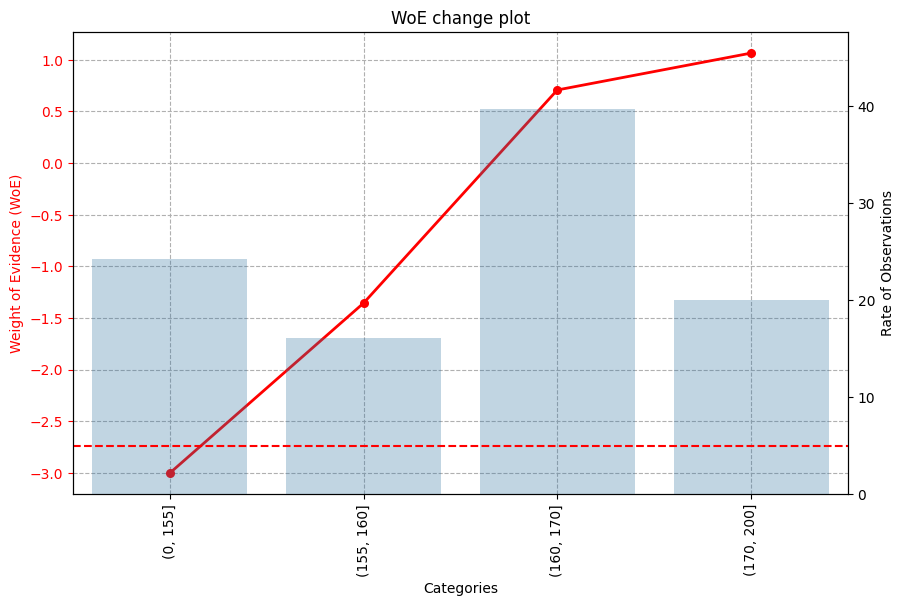

In [ ]:
train_df['height_cm_cat'] = pd.cut(train_df['height(cm)'], bins=[0, 155, 160, 170, 200], duplicates='drop')
test_df['height_cm_cat'] = pd.cut(test_df['height(cm)'], bins=[0, 155, 160, 170, 200], duplicates='drop')

woe_height = get_WoE(train_df, 'height_cm_cat', 'smoking', sort=False)
view_WoE(woe_height, 'height_cm_cat', plotly=False)

<ipython-input-99-de5e9ceb7719>:100: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(axes.get_xticklabels(), rotation=rotation)


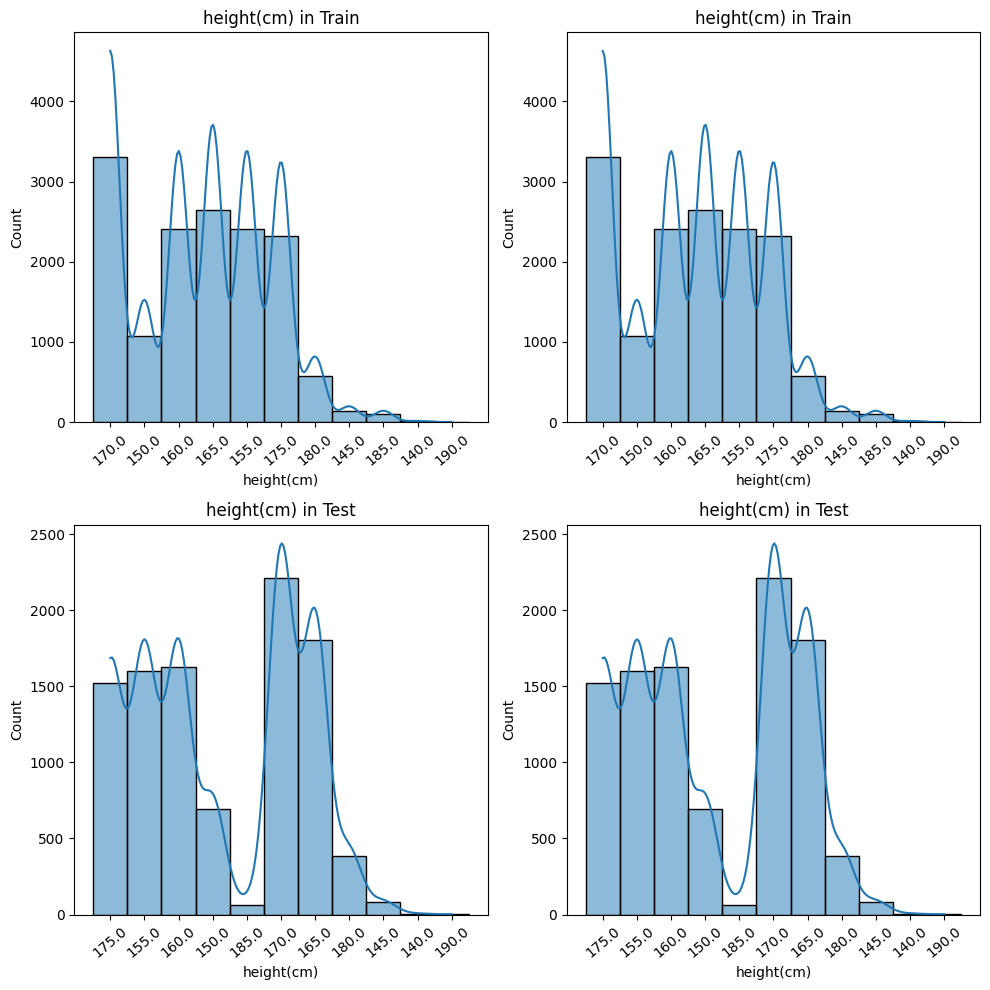

In [ ]:
plot_histograms(train_df, test_df, 'height(cm)', 'height(cm)')

In [ ]:
train_df['height_cm_rank'], train_df['height_cm__woe'] = set_woe(woe_height, train_df, 'height_cm_cat')
test_df['height_cm_rank'], test_df['height_cm__woe'] = set_woe(woe_height, test_df, 'height_cm_cat')

train_df.drop(columns=['height_cm_cat'], axis=1, inplace=True)
test_df.drop(columns=['height_cm_cat'], axis=1, inplace=True)

##### weight(kg)

<ipython-input-99-de5e9ceb7719>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = df.groupby(feature_name)[target_name].value_counts().unstack().rename(columns={1: '# of events', 0: '# of non-events'})


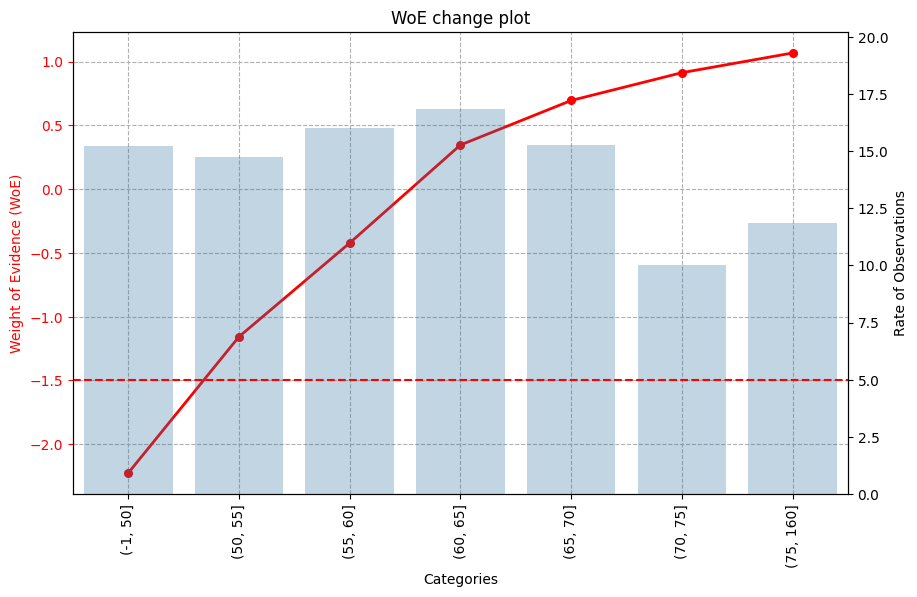

In [ ]:
train_df['weight_kg_cat'] = pd.cut(train_df['weight(kg)'], bins=[-1, 50, 55, 60, 65, 70, 75, 160], duplicates='drop')
test_df['weight_kg_cat'] = pd.cut(test_df['weight(kg)'], bins=[-1, 50, 55, 60, 65, 70, 75,  160], duplicates='drop')

woe_weight = get_WoE(train_df, 'weight_kg_cat', 'smoking', sort=False)
view_WoE(woe_weight, 'weight_kg_cat', plotly=False)

<ipython-input-99-de5e9ceb7719>:100: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(axes.get_xticklabels(), rotation=rotation)


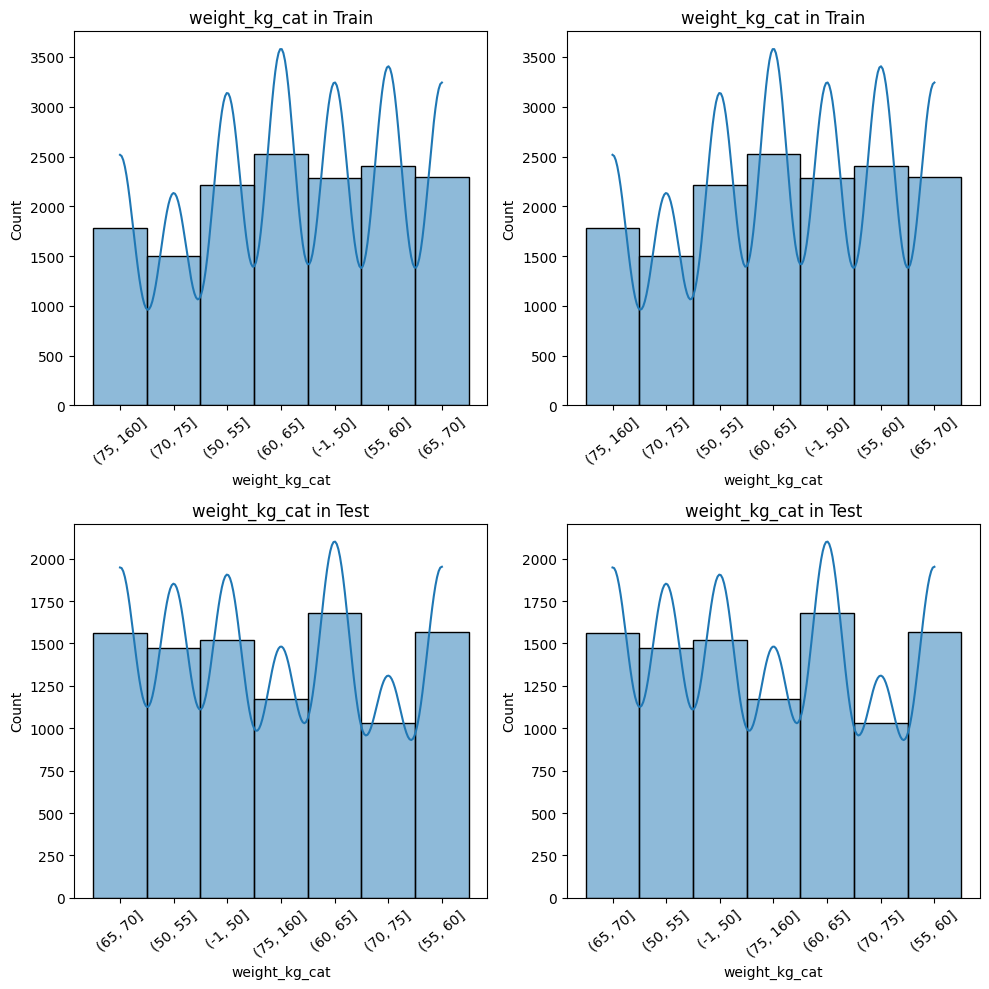

In [ ]:
plot_histograms(train_df, test_df, 'weight_kg_cat', 'weight_kg_cat')

In [ ]:
train_df['weight_kg_rank'], train_df['weight_kg_woe'] = set_woe(woe_weight, train_df, 'weight_kg_cat')
test_df['weight_kg_rank'], test_df['weight_kg_woe'] = set_woe(woe_weight, test_df, 'weight_kg_cat')

train_df.drop(columns=['weight_kg_cat'], axis=1, inplace=True)
test_df.drop(columns=['weight_kg_cat'], axis=1, inplace=True)

##### waist(cm)

<ipython-input-99-de5e9ceb7719>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = df.groupby(feature_name)[target_name].value_counts().unstack().rename(columns={1: '# of events', 0: '# of non-events'})


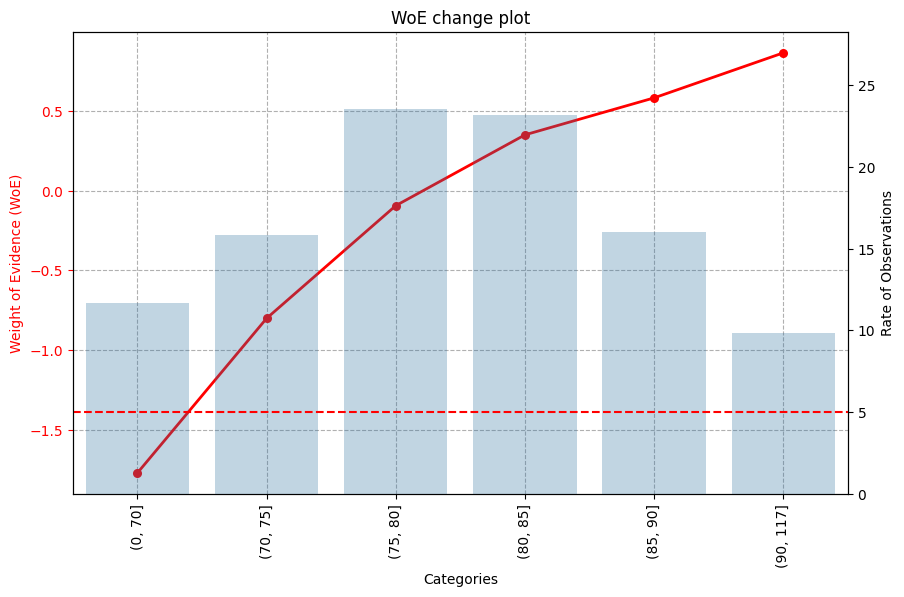

In [ ]:
train_df['weast_cm_cat'] = pd.cut(train_df['waist(cm)'], bins=[0, 70, 75, 80, 85, 90, 117], duplicates='drop')
test_df['weast_cm_cat'] = pd.cut(test_df['waist(cm)'], bins=[0, 70, 75, 80, 85, 90, 117], duplicates='drop')

woe_waist = get_WoE(train_df, 'weast_cm_cat', 'smoking', sort=False)
view_WoE(woe_waist, 'weast_cm_cat', plotly=False)

<ipython-input-99-de5e9ceb7719>:100: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(axes.get_xticklabels(), rotation=rotation)


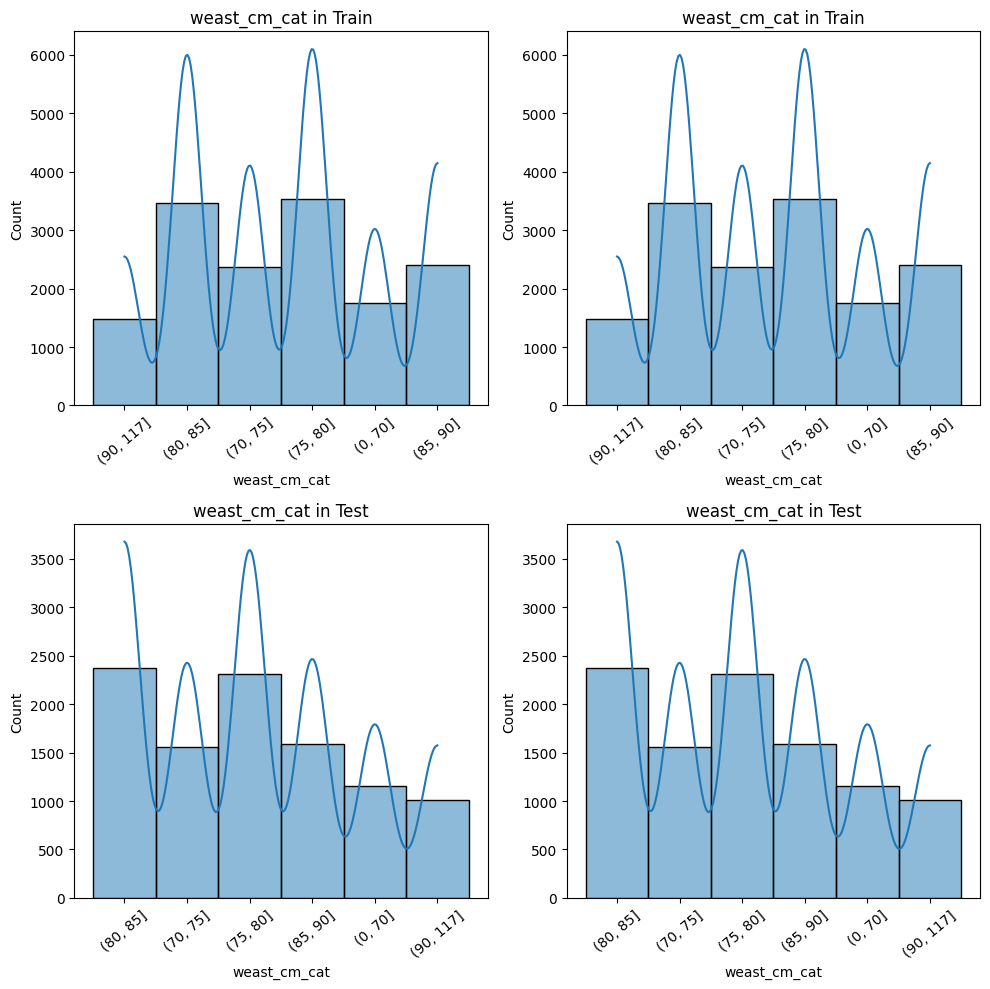

In [ ]:
plot_histograms(train_df, test_df, 'weast_cm_cat', 'weast_cm_cat')

In [ ]:
train_df['weast_cm_rank'], train_df['weast_cm_woe'] = set_woe(woe_waist, train_df, 'weast_cm_cat')
test_df['weast_cm_rank'], test_df['weast_cm_woe'] = set_woe(woe_waist, test_df, 'weast_cm_cat')

train_df.drop(columns=['weast_cm_cat'], axis=1, inplace=True)
test_df.drop(columns=['weast_cm_cat'], axis=1, inplace=True)

##### systolic

In [ ]:
# train_df['systolic_cat'] = pd.cut(train_df['systolic'], bins=[0, 120, 140, 200], duplicates='drop')
# test_df['systolic_cat'] = pd.cut(test_df['systolic'], bins=[0, 120, 140, 200], duplicates='drop')

# woe_systolic = get_WoE(train_df, 'systolic_cat', 'smoking', sort=False)
# view_WoE(woe_systolic, 'systolic_cat', plotly=False)
# plot_histograms(train_df, test_df, 'systolic_cat', 'systolic_cat')
# train_df['systolic_rank'], train_df['systolic_woe'] = set_woe(woe_systolic, train_df, 'systolic_cat')
# test_df['systolic_rank'], test_df['systolic_woe'] = set_woe(woe_systolic, test_df, 'systolic_cat')

# train_df.drop(columns=['systolic_cat'], axis=1, inplace=True)
# test_df.drop(columns=['systolic_cat'], axis=1, inplace=True)

##### fasting blood sugar

In [ ]:
# train_df['fasting_blood_sugar_cat'] = pd.cut(train_df['fasting blood sugar'], bins=[-10, 100, 110, 120, 400], duplicates='drop')
# test_df['fasting_blood_sugar_cat'] = pd.cut(test_df['fasting blood sugar'], bins=[-10, 100, 110, 120, 400], duplicates='drop')

# woe_fasting_blood_sugar = get_WoE(train_df, 'fasting_blood_sugar_cat', 'smoking', sort=False)
# view_WoE(woe_fasting_blood_sugar, 'fasting_blood_sugar_cat', plotly=False)

In [ ]:
# train_df['fasting_blood_sugar_rank'], train_df['fasting_blood_sugar_woe'] = set_woe(woe_fasting_blood_sugar, train_df, 'fasting_blood_sugar_cat')
# test_df['fasting_blood_sugar_rank'], test_df['fasting_blood_sugar_woe'] = set_woe(woe_fasting_blood_sugar, test_df, 'fasting_blood_sugar_cat')

# train_df.drop(columns=['fasting_blood_sugar_cat'], axis=1, inplace=True)
# test_df.drop(columns=['fasting_blood_sugar_cat'], axis=1, inplace=True)

##### triglyceride

<ipython-input-99-de5e9ceb7719>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = df.groupby(feature_name)[target_name].value_counts().unstack().rename(columns={1: '# of events', 0: '# of non-events'})


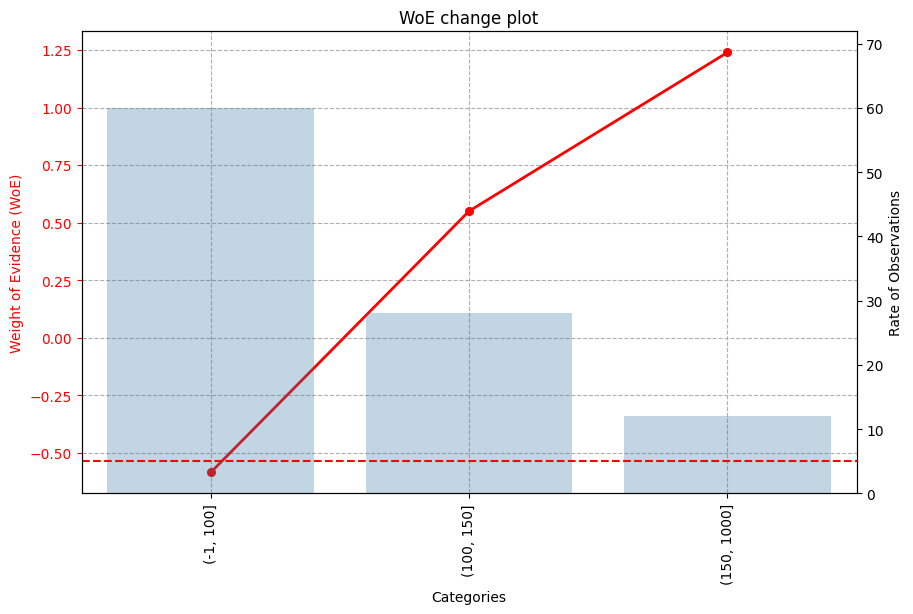

<ipython-input-99-de5e9ceb7719>:100: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(axes.get_xticklabels(), rotation=rotation)


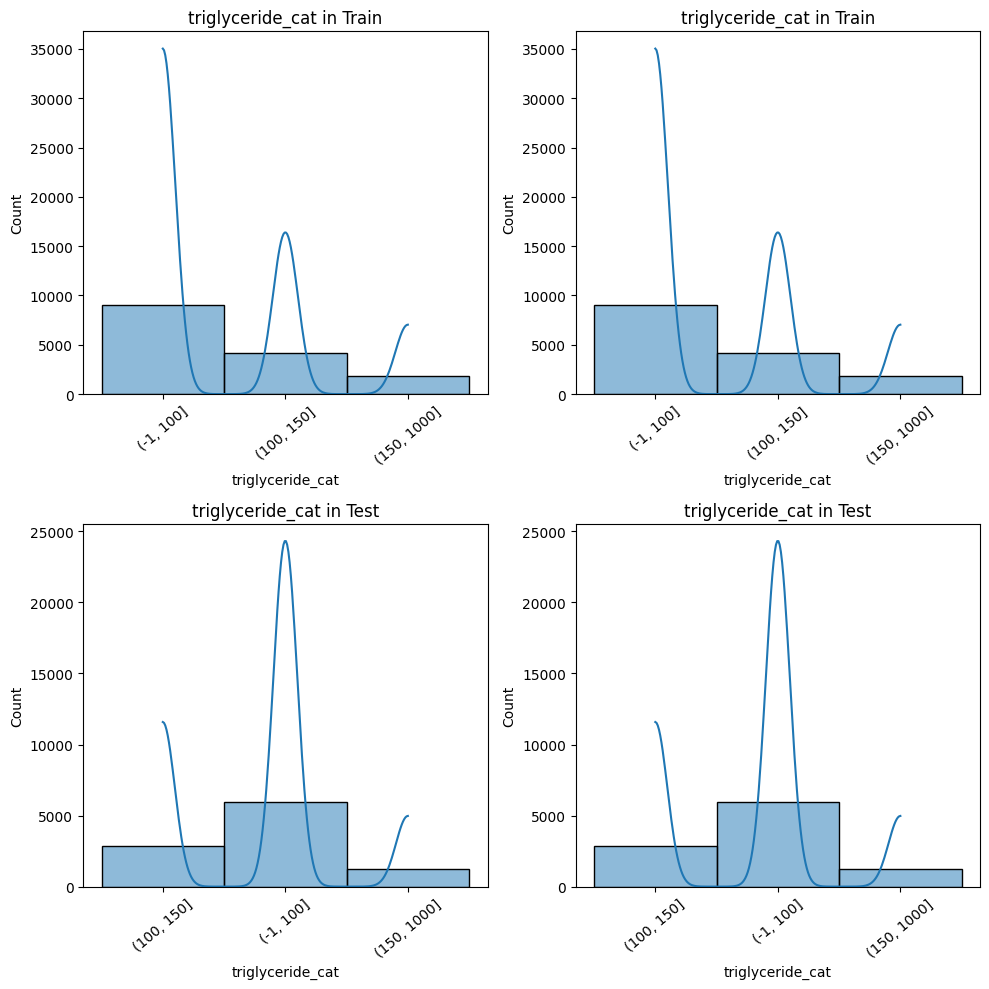

In [ ]:
train_df['triglyceride_cat'] = pd.cut(train_df['triglyceride'], bins=[-1, 100, 150, 1000], duplicates='drop')
test_df['triglyceride_cat'] = pd.cut(test_df['triglyceride'], bins=[-1, 100, 150, 1000], duplicates='drop')

woe_triglyceride = get_WoE(train_df, 'triglyceride_cat', 'smoking', sort=False)
view_WoE(woe_triglyceride, 'triglyceride_cat', plotly=False)
plot_histograms(train_df, test_df, 'triglyceride_cat', 'triglyceride_cat')
train_df['triglyceride_rank'], train_df['triglyceride_woe'] = set_woe(woe_triglyceride, train_df, 'triglyceride_cat')
test_df['triglyceride_rank'], test_df['triglyceride_woe'] = set_woe(woe_triglyceride, test_df, 'triglyceride_cat')

train_df.drop(columns=['triglyceride_cat'], axis=1, inplace=True)
test_df.drop(columns=['triglyceride_cat'], axis=1, inplace=True)

##### HDL

<ipython-input-99-de5e9ceb7719>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = df.groupby(feature_name)[target_name].value_counts().unstack().rename(columns={1: '# of events', 0: '# of non-events'})


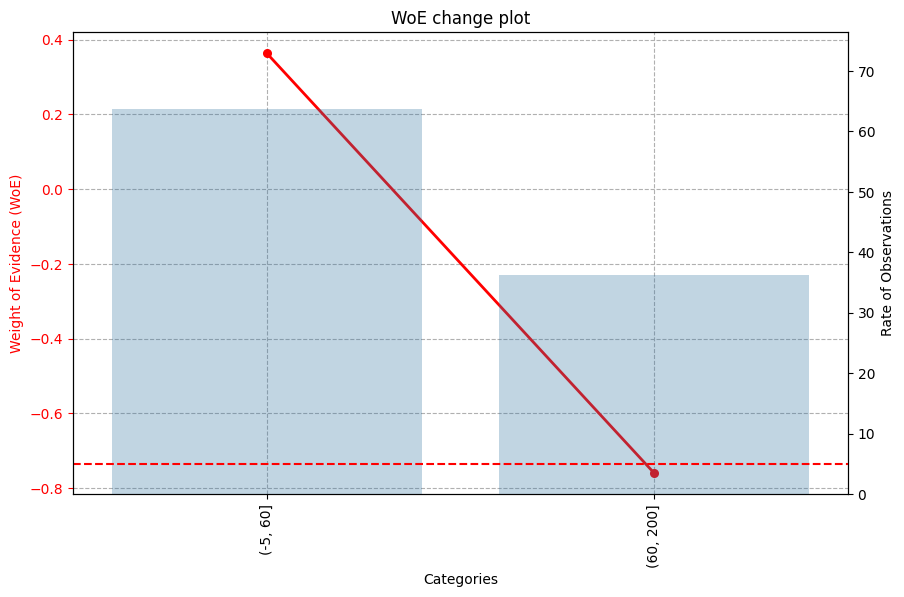

<ipython-input-99-de5e9ceb7719>:100: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(axes.get_xticklabels(), rotation=rotation)


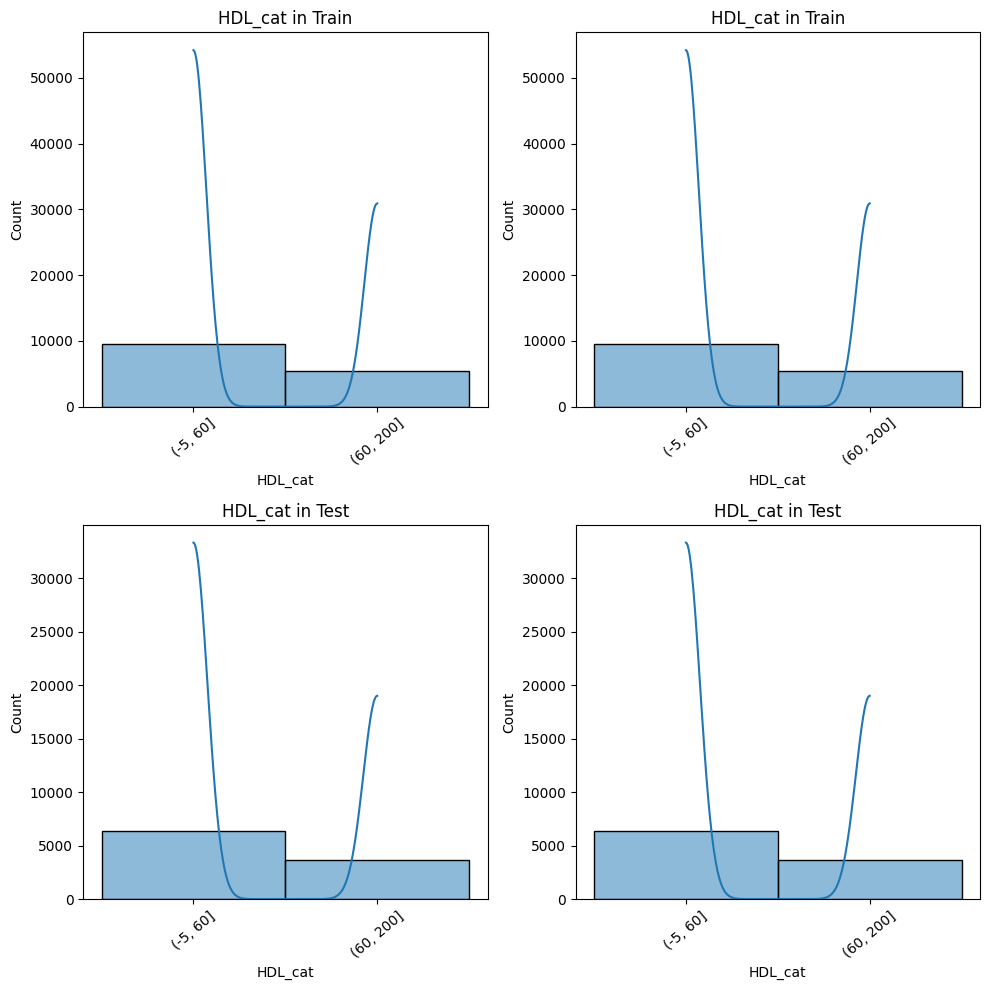

In [ ]:
train_df['HDL_cat'] = pd.cut(train_df['HDL'], bins=[-5, 60, 200], duplicates='drop')
test_df['HDL_cat'] = pd.cut(test_df['HDL'], bins=[-5, 60, 200], duplicates='drop')

woe_HDL = get_WoE(train_df, 'HDL_cat', 'smoking', sort=False)
view_WoE(woe_HDL, 'HDL_cat', plotly=False)
plot_histograms(train_df, test_df, 'HDL_cat', 'HDL_cat')
train_df['HDL_rank'], train_df['HDL_woe'] = set_woe(woe_HDL, train_df, 'HDL_cat')
test_df['HDL_rank'], test_df['HDL_woe'] = set_woe(woe_HDL, test_df, 'HDL_cat')

train_df.drop(columns=['HDL_cat'], axis=1, inplace=True)
test_df.drop(columns=['HDL_cat'], axis=1, inplace=True)

##### hemoglobin

<ipython-input-99-de5e9ceb7719>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = df.groupby(feature_name)[target_name].value_counts().unstack().rename(columns={1: '# of events', 0: '# of non-events'})


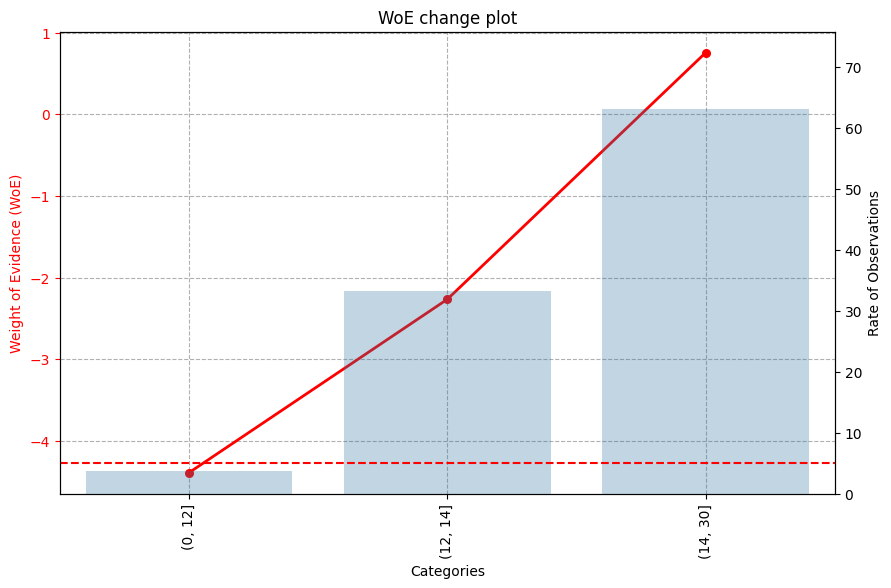

<ipython-input-99-de5e9ceb7719>:100: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(axes.get_xticklabels(), rotation=rotation)


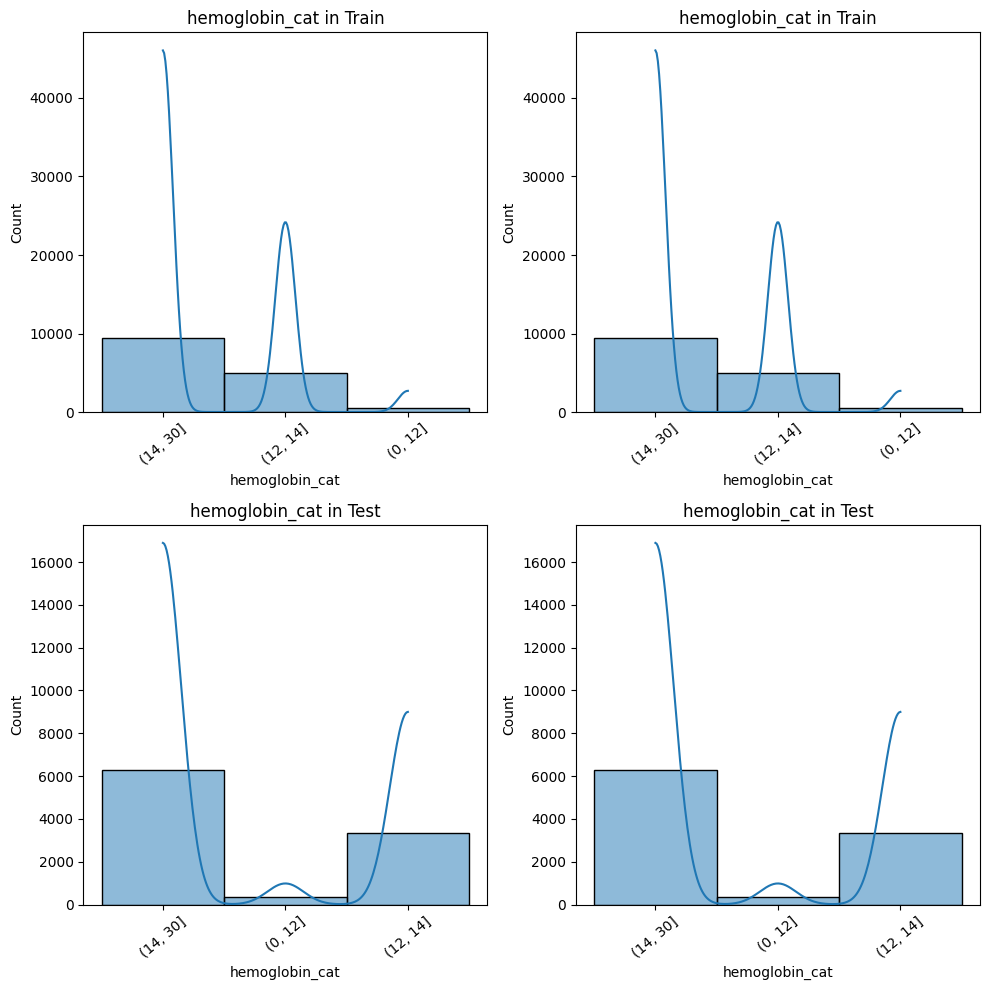

In [ ]:
train_df['hemoglobin_cat'] = pd.cut(train_df['hemoglobin'], bins=[0, 12, 14, 30], duplicates='drop')
test_df['hemoglobin_cat'] = pd.cut(test_df['hemoglobin'], bins=[0, 12, 14, 30], duplicates='drop')

woe_hemoglobin = get_WoE(train_df, 'hemoglobin_cat', 'smoking', sort=False)
view_WoE(woe_hemoglobin, 'hemoglobin_cat', plotly=False)
plot_histograms(train_df, test_df, 'hemoglobin_cat', 'hemoglobin_cat')
train_df['hemoglobin_rank'], train_df['hemoglobin_woe'] = set_woe(woe_hemoglobin, train_df, 'hemoglobin_cat')
test_df['hemoglobin_rank'], test_df['hemoglobin_woe'] = set_woe(woe_hemoglobin, test_df, 'hemoglobin_cat')

train_df.drop(columns=['hemoglobin_cat'], axis=1, inplace=True)
test_df.drop(columns=['hemoglobin_cat'], axis=1, inplace=True)

##### serum creatinine

In [ ]:
# train_df['serum_creatinine_cat'] = pd.cut(train_df['serum creatinine'], bins=[0, 0.9, 1.1, 5], duplicates='drop')
# test_df['serum_creatinine_cat'] = pd.cut(test_df['serum creatinine'], bins=[0, 0.9, 1.1, 5], duplicates='drop')

# woe_serum_creatinine = get_WoE(train_df, 'serum_creatinine_cat', 'smoking', sort=False)
# view_WoE(woe_serum_creatinine, 'serum_creatinine_cat', plotly=False)
# plot_histograms(train_df, test_df, 'serum_creatinine_cat', 'serum_creatinine_cat')
# train_df['serum_creatinine_rank'], train_df['serum_creatinine_woe'] = set_woe(woe_serum_creatinine, train_df, 'serum_creatinine_cat')
# test_df['serum_creatinine_rank'], test_df['serum_creatinine_woe'] = set_woe(woe_serum_creatinine, test_df, 'serum_creatinine_cat')

# train_df.drop(columns=['serum_creatinine_cat'], axis=1, inplace=True)
# test_df.drop(columns=['serum_creatinine_cat'], axis=1, inplace=True)

##### AST

<ipython-input-99-de5e9ceb7719>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = df.groupby(feature_name)[target_name].value_counts().unstack().rename(columns={1: '# of events', 0: '# of non-events'})


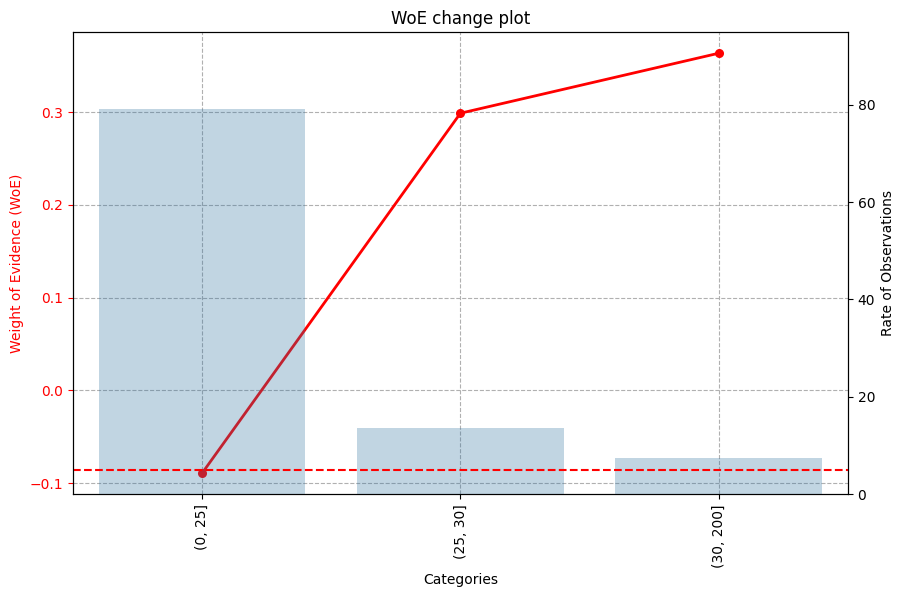

<ipython-input-99-de5e9ceb7719>:100: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(axes.get_xticklabels(), rotation=rotation)


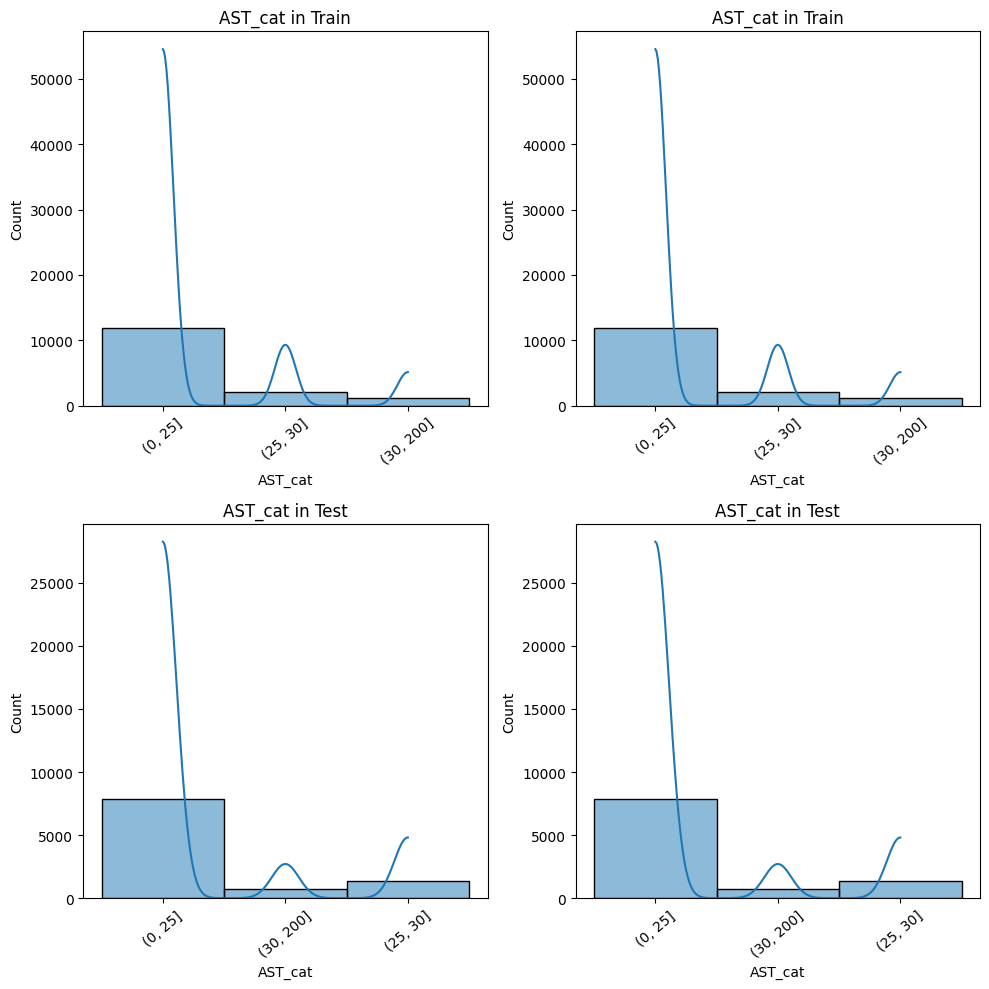

In [ ]:
train_df['AST_cat'] = pd.cut(train_df['AST'], bins=[0, 25, 30, 200], duplicates='drop')
test_df['AST_cat'] = pd.cut(test_df['AST'], bins=[0, 25, 30, 200], duplicates='drop')

woe_AST = get_WoE(train_df, 'AST_cat', 'smoking', sort=False)
view_WoE(woe_AST, 'AST_cat', plotly=False)
plot_histograms(train_df, test_df, 'AST_cat', 'AST_cat')
train_df['AST_rank'], train_df['AST_woe'] = set_woe(woe_AST, train_df, 'AST_cat')
test_df['AST_rank'], test_df['AST_woe'] = set_woe(woe_AST, test_df, 'AST_cat')

train_df.drop(columns=['AST_cat'], axis=1, inplace=True)
test_df.drop(columns=['AST_cat'], axis=1, inplace=True)

##### ALT

<ipython-input-99-de5e9ceb7719>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = df.groupby(feature_name)[target_name].value_counts().unstack().rename(columns={1: '# of events', 0: '# of non-events'})


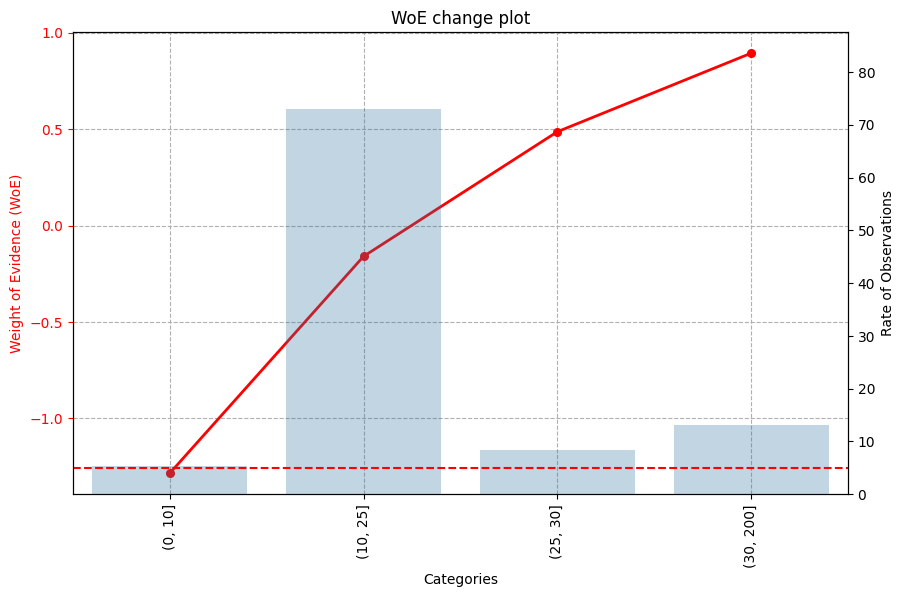

<ipython-input-99-de5e9ceb7719>:100: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(axes.get_xticklabels(), rotation=rotation)


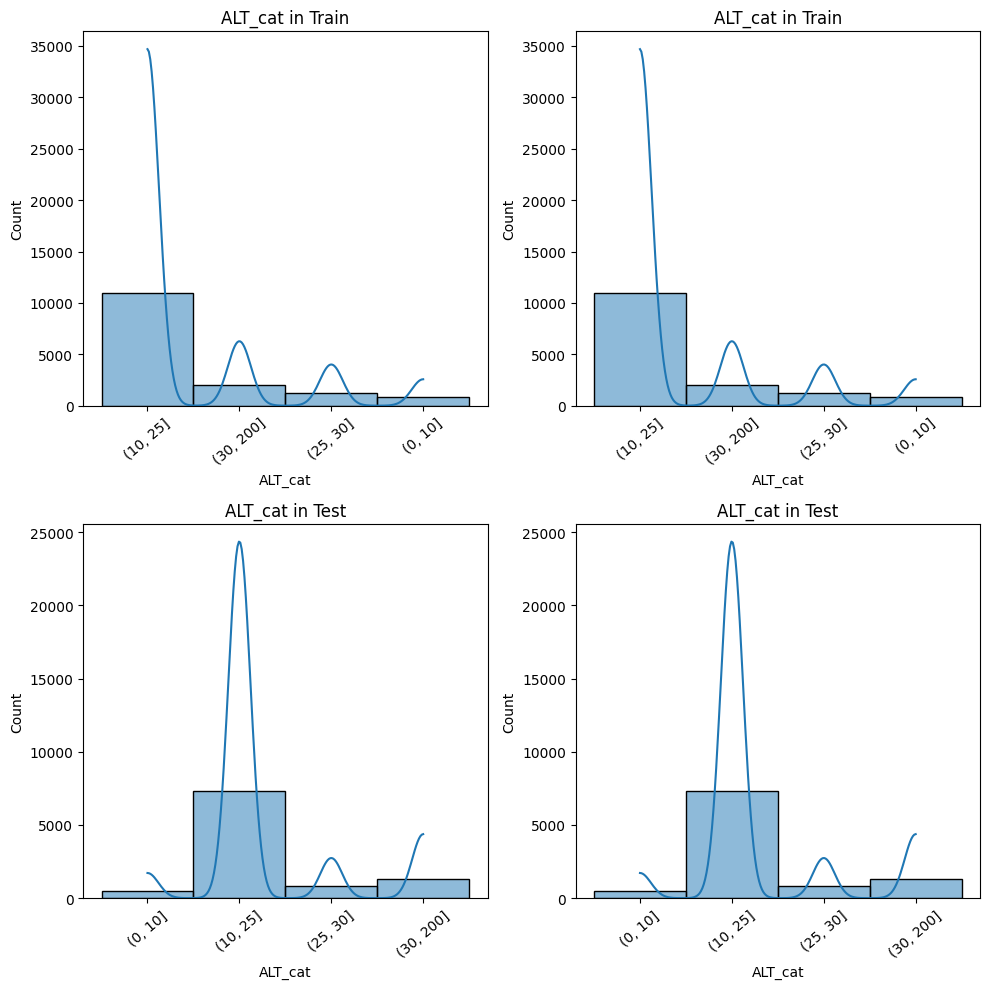

In [ ]:
train_df['ALT_cat'] = pd.cut(train_df['ALT'], bins=[0,10,  10, 25, 30, 200], duplicates='drop')
test_df['ALT_cat'] = pd.cut(test_df['ALT'], bins=[0, 10, 25, 30, 200], duplicates='drop')

woe_ALT = get_WoE(train_df, 'ALT_cat', 'smoking', sort=False)
view_WoE(woe_ALT, 'ALT_cat', plotly=False)
plot_histograms(train_df, test_df, 'ALT_cat', 'ALT_cat')
train_df['ALT_rank'], train_df['ALT_woe'] = set_woe(woe_ALT, train_df, 'ALT_cat')
test_df['ALT_rank'], test_df['ALT_woe'] = set_woe(woe_ALT, test_df, 'ALT_cat')

train_df.drop(columns=['ALT_cat'], axis=1, inplace=True)
test_df.drop(columns=['ALT_cat'], axis=1, inplace=True)

##### Gtp

<ipython-input-99-de5e9ceb7719>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = df.groupby(feature_name)[target_name].value_counts().unstack().rename(columns={1: '# of events', 0: '# of non-events'})


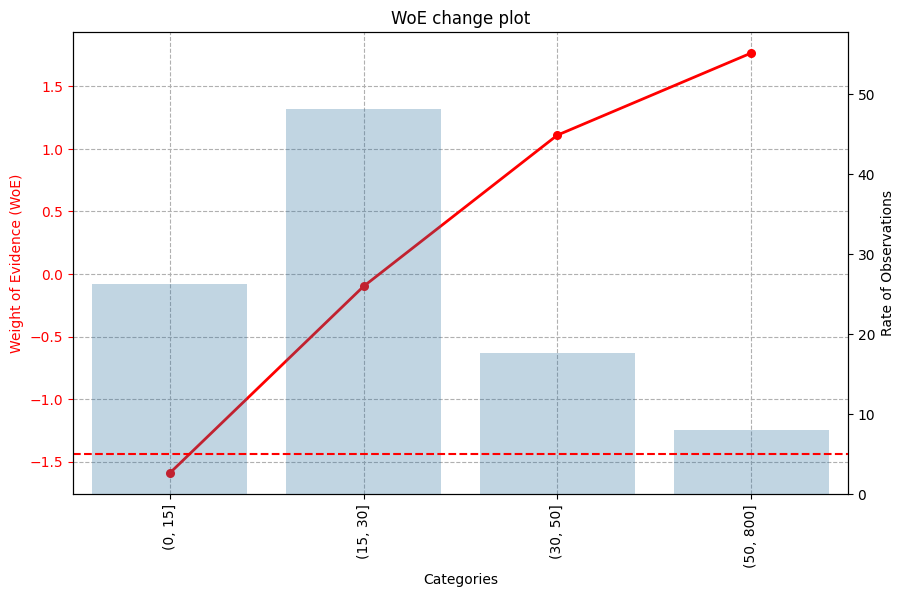

<ipython-input-99-de5e9ceb7719>:100: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(axes.get_xticklabels(), rotation=rotation)


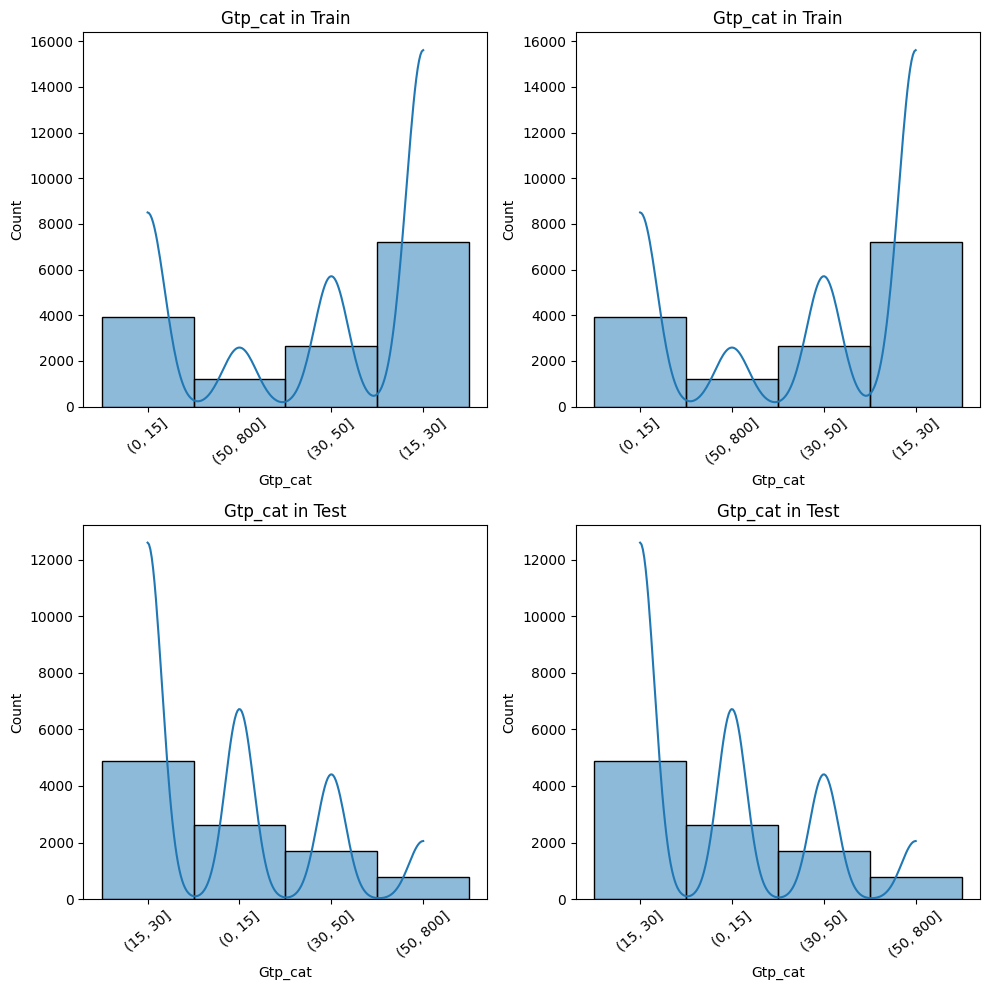

In [ ]:
train_df['Gtp_cat'] = pd.cut(train_df['Gtp'], bins=[0, 15, 30, 50, 800], duplicates='drop')
test_df['Gtp_cat'] = pd.cut(test_df['Gtp'], bins=[0, 15, 30, 50, 800], duplicates='drop')

woe_Gtp = get_WoE(train_df, 'Gtp_cat', 'smoking', sort=False)
view_WoE(woe_Gtp, 'Gtp_cat', plotly=False)
plot_histograms(train_df, test_df, 'Gtp_cat', 'Gtp_cat')
train_df['Gtp_rank'], train_df['Gtp_woe'] = set_woe(woe_Gtp, train_df, 'Gtp_cat')
test_df['Gtp_rank'], test_df['Gtp_woe'] = set_woe(woe_Gtp, test_df, 'Gtp_cat')

train_df.drop(columns=['Gtp_cat'], axis=1, inplace=True)
test_df.drop(columns=['Gtp_cat'], axis=1, inplace=True)

##### dental caries

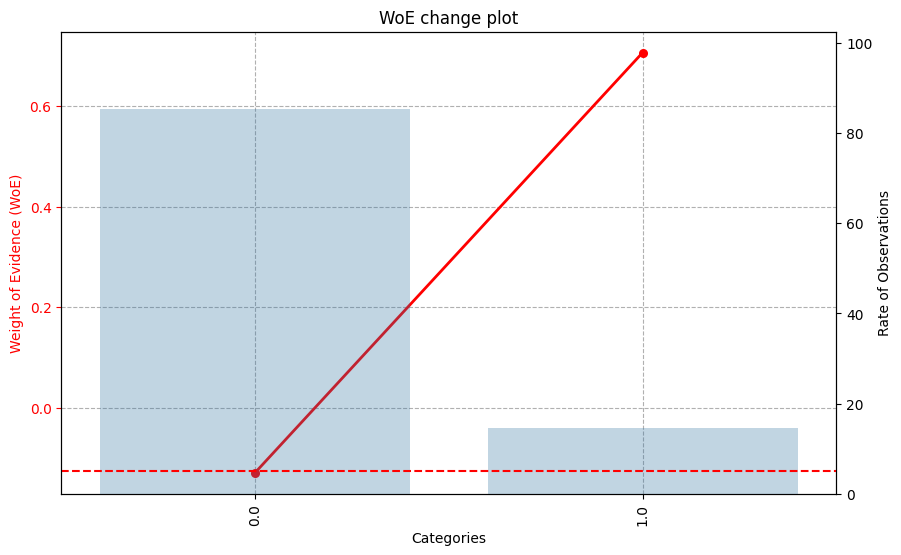

<ipython-input-99-de5e9ceb7719>:100: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(axes.get_xticklabels(), rotation=rotation)


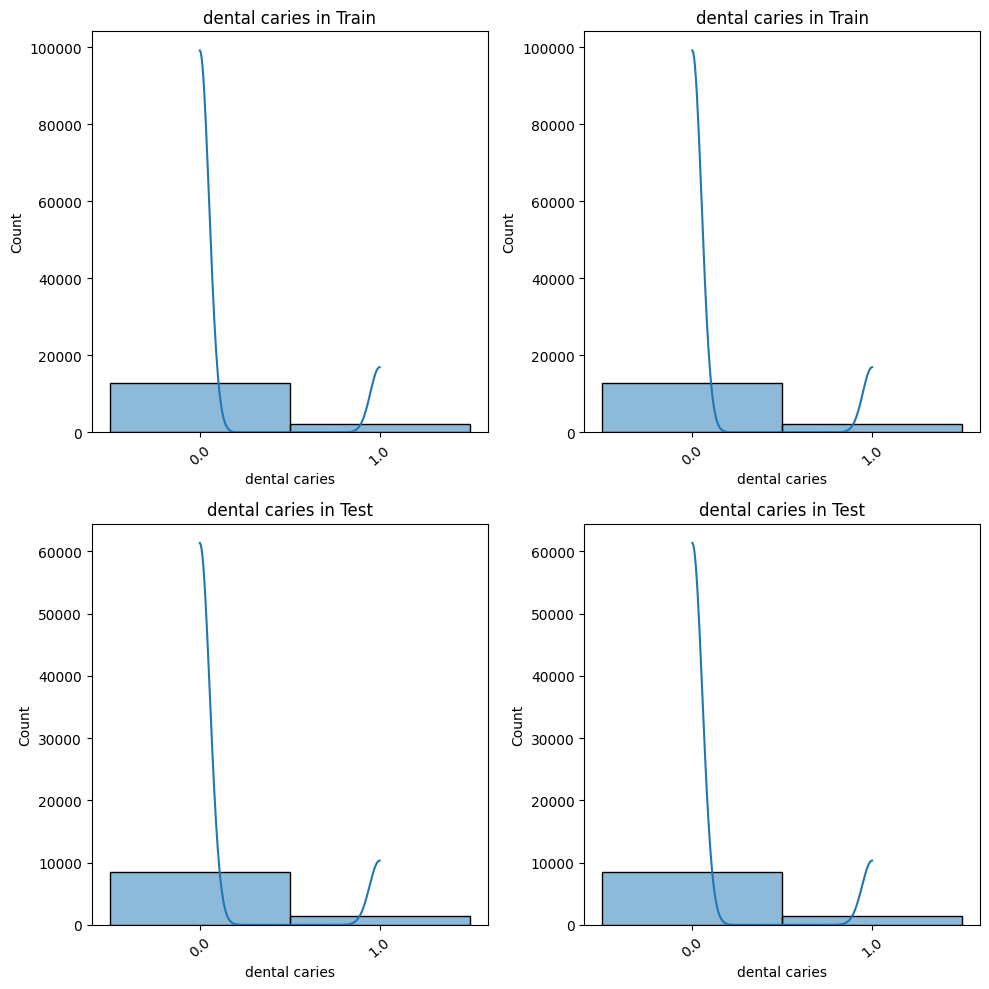

In [ ]:
woe_dental_caries = get_WoE(train_df, 'dental caries', 'smoking', sort=False)
view_WoE(woe_dental_caries, 'dental caries', plotly=False)
plot_histograms(train_df, test_df, 'dental caries', 'dental caries')
train_df['dental_caries_rank'], train_df['dental_caries_woe'] = set_woe(woe_dental_caries, train_df, 'dental caries')
test_df['dental_caries_rank'], test_df['dental_caries_woe'] = set_woe(woe_dental_caries, test_df, 'dental caries')

##### waist_height_ratio

In [ ]:
# woe_waist_height_ratio = get_WoE(train_df, 'waist_height_ratio', 'smoking', sort=False)
# view_WoE(woe_waist_height_ratio, 'waist_height_ratio', plotly=False)
# plot_histograms(train_df, test_df, 'waist_height_ratio', 'waist_height_ratio')
# train_df['waist_height_ratio_rank'], train_df['waist_height_ratio_woe'] = set_woe(woe_waist_height_ratio, train_df, 'waist_height_ratio')
# test_df['waist_height_ratio_rank'], test_df['waist_height_ratio_woe'] = set_woe(woe_waist_height_ratio, test_df, 'waist_height_ratio')

##### cholesterol_ratio

In [ ]:
# train_df['cholesterol_ratio_cat'] = pd.cut(train_df['cholesterol_ratio'], bins=[-1, 0.5, 1, 2, 5], duplicates='drop')
# test_df['cholesterol_ratio_cat'] = pd.cut(test_df['cholesterol_ratio'], bins=[-1, 0.5, 1, 2, 5], duplicates='drop')

# woe_cholesterol_ratio = get_WoE(train_df, 'cholesterol_ratio_cat', 'smoking', sort=False)
# view_WoE(woe_cholesterol_ratio, 'cholesterol_ratio_cat', plotly=False)
# plot_histograms(train_df, test_df, 'cholesterol_ratio_cat', 'cholesterol_ratio_cat')
# train_df['cholesterol_ratio_rank'], train_df['cholesterol_ratio_woe'] = set_woe(woe_cholesterol_ratio, train_df, 'cholesterol_ratio_cat')
# test_df['cholesterol_ratio_rank'], test_df['cholesterol_ratio_woe'] = set_woe(woe_cholesterol_ratio, test_df, 'cholesterol_ratio_cat')

# train_df.drop(columns=['cholesterol_ratio_cat'], axis=1, inplace=True)
# test_df.drop(columns=['cholesterol_ratio_cat'], axis=1, inplace=True)

##### Liver_Enzyme_Ratio

<ipython-input-99-de5e9ceb7719>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = df.groupby(feature_name)[target_name].value_counts().unstack().rename(columns={1: '# of events', 0: '# of non-events'})


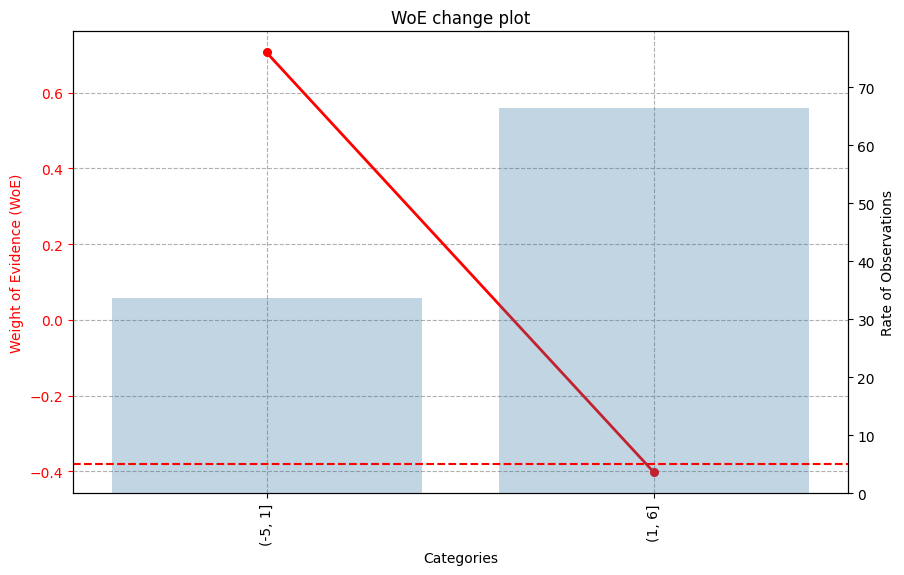

<ipython-input-99-de5e9ceb7719>:100: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(axes.get_xticklabels(), rotation=rotation)


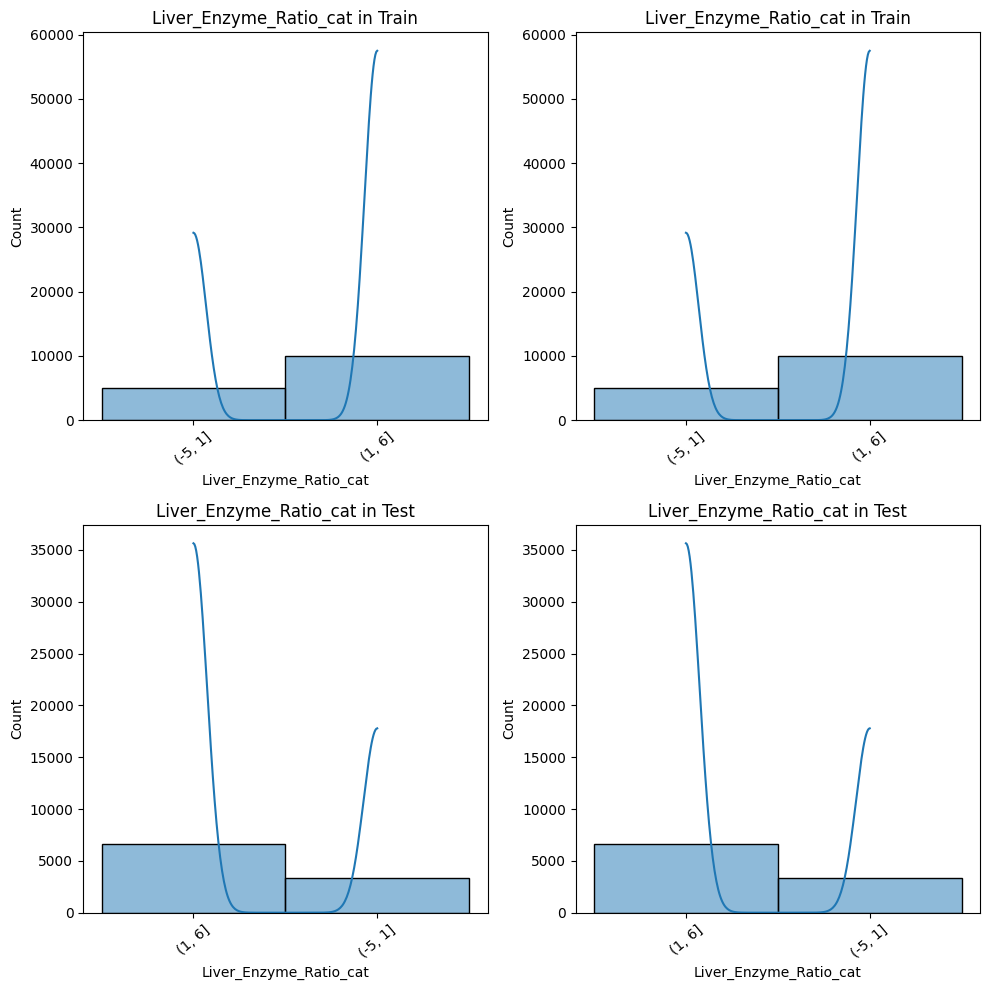

In [ ]:
train_df['Liver_Enzyme_Ratio_cat'] = pd.cut(train_df['Liver_Enzyme_Ratio'], bins=[-5, 1, 6], duplicates='drop')
test_df['Liver_Enzyme_Ratio_cat'] = pd.cut(test_df['Liver_Enzyme_Ratio'], bins=[-5, 1, 6], duplicates='drop')

woe_Liver_Enzyme_Ratio = get_WoE(train_df, 'Liver_Enzyme_Ratio_cat', 'smoking', sort=False)
view_WoE(woe_Liver_Enzyme_Ratio, 'Liver_Enzyme_Ratio_cat', plotly=False)
plot_histograms(train_df, test_df, 'Liver_Enzyme_Ratio_cat', 'Liver_Enzyme_Ratio_cat')
train_df['Liver_Enzyme_Ratio_rank'], train_df['Liver_Enzyme_Ratio_woe'] = set_woe(woe_Liver_Enzyme_Ratio, train_df, 'Liver_Enzyme_Ratio_cat')
test_df['Liver_Enzyme_Ratio_rank'], test_df['Liver_Enzyme_Ratio_woe'] = set_woe(woe_Liver_Enzyme_Ratio, test_df, 'Liver_Enzyme_Ratio_cat')

train_df.drop(columns=['Liver_Enzyme_Ratio_cat'], axis=1, inplace=True)
test_df.drop(columns=['Liver_Enzyme_Ratio_cat'], axis=1, inplace=True)

##### Hemoglobin_GTP_Ratio

In [ ]:
# # prompt: for 'Hemoglobin_GTP_Ratio'  columns woe as before

# train_df['Hemoglobin_GTP_Ratio_cat'] = pd.cut(train_df['Hemoglobin_GTP_Ratio'], bins=[-1, 0.5, 1, 2, 5], duplicates='drop')
# test_df['Hemoglobin_GTP_Ratio_cat'] = pd.cut(test_df['Hemoglobin_GTP_Ratio'], bins=[-1, 0.5, 1, 2, 5], duplicates='drop')

# woe_Hemoglobin_GTP_Ratio = get_WoE(train_df, 'Hemoglobin_GTP_Ratio_cat', 'smoking', sort=False)
# view_WoE(woe_Hemoglobin_GTP_Ratio, 'Hemoglobin_GTP_Ratio_cat', plotly=False)
# plot_histograms(train_df, test_df, 'Hemoglobin_GTP_Ratio_cat', 'Hemoglobin_GTP_Ratio_cat')
# train_df['Hemoglobin_GTP_Ratio_rank'], train_df['Hemoglobin_GTP_Ratio_woe'] = set_woe(woe_Hemoglobin_GTP_Ratio, train_df, 'Hemoglobin_GTP_Ratio_cat')
# test_df['Hemoglobin_GTP_Ratio_rank'], test_df['Hemoglobin_GTP_Ratio_woe'] = set_woe(woe_Hemoglobin_GTP_Ratio, test_df, 'Hemoglobin_GTP_Ratio_cat')

# train_df.drop(columns=['Hemoglobin_GTP_Ratio_cat'], axis=1, inplace=True)
# test_df.drop(columns=['Hemoglobin_GTP_Ratio_cat'], axis=1, inplace=True)

##### blood_pressure_category

In [ ]:
woe_blood_pressure_category = get_WoE(train_df, 'blood_pressure_category', 'smoking', sort=False)
train_df['blood_pressure_category_rank'], train_df['blood_pressure_category_woe'] = set_woe(woe_blood_pressure_category, train_df, 'blood_pressure_category')
test_df['blood_pressure_category_rank'], test_df['blood_pressure_category_woe'] = set_woe(woe_blood_pressure_category, test_df, 'blood_pressure_category')

<ipython-input-99-de5e9ceb7719>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = df.groupby(feature_name)[target_name].value_counts().unstack().rename(columns={1: '# of events', 0: '# of non-events'})


##### Cholesterol

<ipython-input-99-de5e9ceb7719>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = df.groupby(feature_name)[target_name].value_counts().unstack().rename(columns={1: '# of events', 0: '# of non-events'})


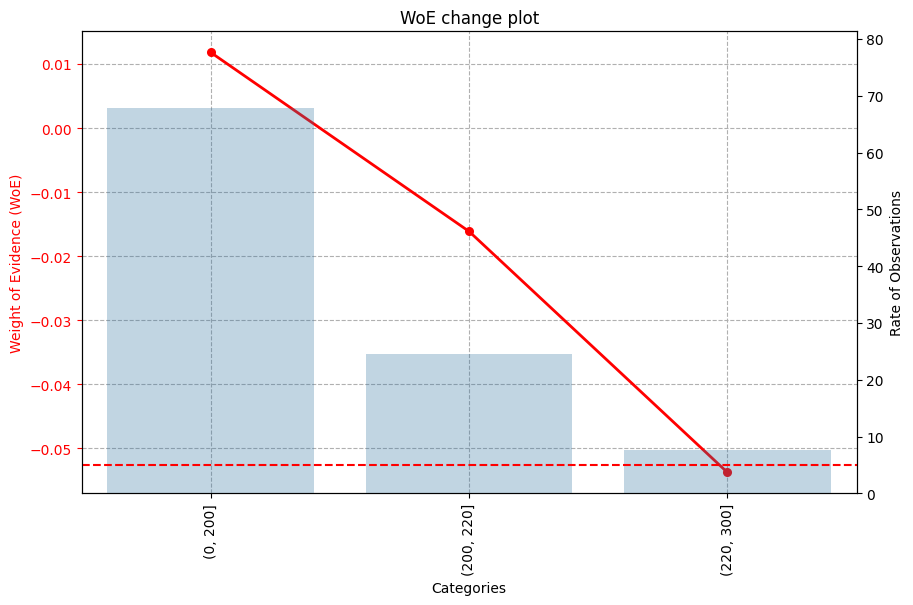

<ipython-input-99-de5e9ceb7719>:100: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(axes.get_xticklabels(), rotation=rotation)


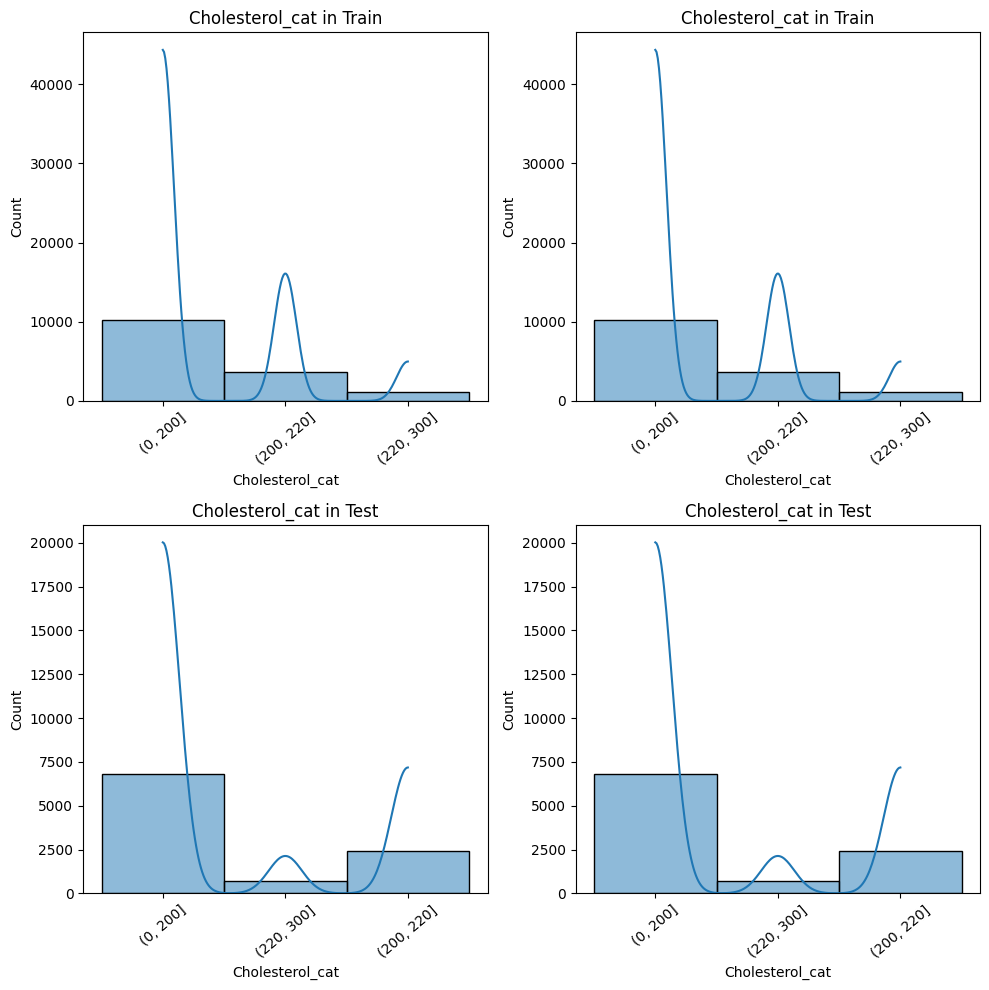

In [ ]:
train_df['Cholesterol_cat'] = pd.cut(train_df['Cholesterol'], bins=[0, 200, 220, 300], duplicates='drop')
test_df['Cholesterol_cat'] = pd.cut(test_df['Cholesterol'], bins=[0, 200, 220, 300], duplicates='drop')

woe_Cholesterol = get_WoE(train_df, 'Cholesterol_cat', 'smoking', sort=False)
view_WoE(woe_Cholesterol, 'Cholesterol_cat', plotly=False)
plot_histograms(train_df, test_df, 'Cholesterol_cat', 'Cholesterol_cat')
train_df['Cholesterol_rank'], train_df['Cholesterol_woe'] = set_woe(woe_Cholesterol, train_df, 'Cholesterol_cat')
test_df['Cholesterol_rank'], test_df['Cholesterol_woe'] = set_woe(woe_Cholesterol, test_df, 'Cholesterol_cat')

train_df.drop(columns=['Cholesterol_cat'], axis=1, inplace=True)
test_df.drop(columns=['Cholesterol_cat'], axis=1, inplace=True)

## Model

### Test Model

In [ ]:
X = train_df.drop(columns=['smoking'], axis=1)
y = train_df['smoking']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

dt_model = DecisionTreeClassifier(criterion='entropy',
                                  max_depth=5,
                                  random_state=1)

ridge_model = RidgeClassifier(random_state=1,
                               solver='lsqr',
                               alpha=11.6)


logistic_model = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('model', LogisticRegression(max_iter=10000,
                                 C=0.01,
                                 random_state=1,
                                 tol=0.0003857153134400328,
                                 solver='liblinear'))
])

rf_model = RandomForestClassifier(random_state=1,
                                  criterion='entropy',
                                  max_depth=10,
                                  min_impurity_decrease=0.001,
                                  n_estimators=300,
                                  min_samples_split=6,
                                  min_samples_leaf=1)

p_rf_model = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('model', rf_model)
])

gausnb_model = GaussianNB()
svc_model = SVC()
nue_svc_model = NuSVC()
quadratid_model = QuadraticDiscriminantAnalysis()
lineard_model = LinearDiscriminantAnalysis()
extratree_model = ExtraTreesClassifier(max_depth=5)


estimators = [
    ('ridge', ridge_model),
    ('dt', dt_model),
    ('svc', svc_model),
    ('nue', nue_svc_model),
    ('qd', quadratid_model),
    ('ext', extratree_model),
    ('ld', lineard_model),
    ('gaus', gausnb_model),
    ('lr', logistic_model),
    ('rf', p_rf_model)
]


base_model = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('model', LogisticRegression(max_iter=10000,
                                 C=0.01,
                                 random_state=1,
                                 tol=0.0003857153134400328,
                                 solver='liblinear'))
])


stk = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)


ensemble_model = StackingClassifier(estimators=estimators,
                                    final_estimator=base_model,
                                    cv=stk
                                    )

calibrated_model = CalibratedClassifierCV(ensemble_model, method='sigmoid', cv=stk)


cross_val_roc = cross_val_score(ensemble_model, X_train, y_train, cv=stk, scoring='roc_auc')

ensemble_model.fit(X_train, y_train)

train_roc = roc_auc_score(y_train, ensemble_model.predict_proba(X_train)[:,1])
test_roc = roc_auc_score(y_test, ensemble_model.predict_proba(X_test)[:,1])

diff_cv = cross_val_roc.mean() - test_roc

diff_train = train_roc - test_roc

print(f'Cross-validated ROC-AUC: {cross_val_roc.mean():.6f} ± {cross_val_roc.std():.6f}')
print(f'Training ROC-AUC: {train_roc:.6f}')
print(f'Testing ROC-AUC: {test_roc:.6f}')
print(f'Difference (Train - Test): {diff_train:.6f}')
print(f'Difference (Cross-Val - Test): {diff_cv:.6f}')

/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/disc

Cross-validated ROC-AUC: 0.881393 ± 0.005817
Training ROC-AUC: 0.908147
Testing ROC-AUC: 0.890195
Difference (Train - Test): 0.017952
Difference (Cross-Val - Test): -0.008803


### Production Model

In [ ]:
X = train_df.drop(columns=['smoking'], axis=1)
y = train_df['smoking']

dt_model = DecisionTreeClassifier(criterion='entropy',
                                  max_depth=5,
                                  random_state=1)

ridge_model = RidgeClassifier(random_state=1,
                               solver='lsqr',
                               alpha=11.6)


logistic_model = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('model', LogisticRegression(max_iter=10000,
                                 C=0.01,
                                 random_state=1,
                                 tol=0.0003857153134400328,
                                 solver='liblinear'))
])

rf_model = RandomForestClassifier(random_state=1,
                                  criterion='entropy',
                                  max_depth=10,
                                  min_impurity_decrease=0.001,
                                  n_estimators=300,
                                  min_samples_split=6,
                                  min_samples_leaf=1)

p_rf_model = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('model', rf_model)
])

gausnb_model = GaussianNB()
svc_model = SVC()
nue_svc_model = NuSVC()
quadratid_model = QuadraticDiscriminantAnalysis()
lineard_model = LinearDiscriminantAnalysis()
extratree_model = ExtraTreesClassifier(max_depth=5)


estimators = [
    ('ridge', ridge_model),
    ('dt', dt_model),
    ('svc', svc_model),
    ('nue', nue_svc_model),
    ('qd', quadratid_model),
    ('ext', extratree_model),
    ('ld', lineard_model),
    ('gaus', gausnb_model),
    ('lr', logistic_model),
    ('rf', p_rf_model)
]


base_model = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('model', LogisticRegression(max_iter=10000,
                                 C=0.01,
                                 random_state=1,
                                 tol=0.0003857153134400328,
                                 solver='liblinear'))
])


stk = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)


final_model = StackingClassifier(estimators=estimators,
                                 final_estimator=base_model,
                                 cv=stk
                                  )

calibrated_model = CalibratedClassifierCV(final_model, method='sigmoid', cv=stk)

final_model.fit(X, y)

/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


StackingClassifier(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
                   estimators=[('ridge',
                                RidgeClassifier(alpha=11.6, random_state=1,
                                                solver='lsqr')),
                               ('dt',
                                DecisionTreeClassifier(criterion='entropy',
                                                       max_depth=5,
                                                       random_state=1)),
                               ('svc', SVC()), ('nue', NuSVC()),
                               ('qd', QuadraticDiscriminantAnalysis()),
                               ('ext', ExtraTreesClassifier(max_depth=5)),
                               ('ld...
                                                ('model',
                                                 RandomForestClassifier(criterion='entropy',
                                                                        max_depth=10,
                                                                        min_impurity_decrease=0.001,
                                                                        min_samples_split=6,
                                                                        n_estimators=300,
                                                                        random_state=1))]))],
                   final_estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                                   ('poly',
                                                    PolynomialFeatures()),
                                                   ('model',
                                                    LogisticRegression(C=0.01,
                                                                       max_iter=10000,
                                                                       random_state=1,
                                                                       solver='liblinear',
                                                                       tol=0.0003857153134400328))]))

###### submetion

In [ ]:
y_test_score = final_model.predict_proba(test_df[X.columns])[:, 1]

test_df['smoking'] = y_test_score
test_df[['id', 'smoking']].to_csv('submetion.csv', index=False)

###### Save model's

In [ ]:
dump(final_model, 'smoking_model.joblib')

['smoking_model.joblib']

### Tuning

*An attempt was made to find the best hyperparameters for the model.*

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

def objective(trial):
    # DT
    max_depth_dt = trial.suggest_int("max_depth_dt", 3, 10)


    ## RIDGE
    alpha_ridge = trial.suggest_float("alpha_ridge", 1.0, 20.0)

    # LOGISTEk
    logisteck_params = {
        'tol' : trial.suggest_float('tol' , 1e-6 , 1e-3),
        'C' : trial.suggest_float("C", 0.0001, 5),
        'solver' : trial.suggest_categorical('solver' , ['lbfgs','liblinear'])
    }

    # RF
    max_depth_rf = trial.suggest_int(name="max_depth_rf", low=10, high=110, step=20)
    n_estimators = trial.suggest_int(name="n_estimators", low=100, high=500, step=100)
    min_samples_split_rf = trial.suggest_int(name="min_samples_split_rf", low=2, high=10, step=2)
    min_samples_leaf_rf = trial.suggest_int(name="min_samples_leaf_rf", low=1, high=4, step=1)



    dt_model = DecisionTreeClassifier(criterion='entropy',
                                      max_depth=max_depth_dt,
                                      random_state=1)

    ridge_model = RidgeClassifier(random_state=1,
                                  solver='lsqr',
                                  alpha=alpha_ridge)


    rf_model = RandomForestClassifier(random_state=1,
                                      criterion='entropy',
                                      max_depth=max_depth_rf,
                                      n_estimators=n_estimators,
                                      min_samples_split=min_samples_split_rf,
                                      min_samples_leaf=min_samples_leaf_rf)

    p_rf_model = Pipeline([
        ('poly', PolynomialFeatures(degree=2)),
        ('model', rf_model)
    ])

    lineard_mode = Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=2)),
        ('modeld', LinearDiscriminantAnalysis())
    ])

    estimators = [
        ('ridge', ridge_model),
        ('qd', QuadraticDiscriminantAnalysis()),
        ('ext', ExtraTreesClassifier(max_depth=5)),
        ('ld', lineard_mode),
        ('gaus', GaussianNB()),
        ('rf', p_rf_model)
    ]

    base_model = Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=2)),
        ('model', LogisticRegression(**logisteck_params,
                                     max_iter=10000,
                                     random_state=1))
    ])

    ensemble_model = StackingClassifier(estimators=estimators,
                                        final_estimator=base_model)

    ensemble_model.fit(X_train, y_train)

    test_pred = ensemble_model.predict(X_test)
    train_pred = ensemble_model.predict(X_train)

    test_score = roc_auc_score(y_test, test_pred)
    train_score = roc_auc_score(y_train, train_pred)

    dif = train_score - test_score

    return test_score - dif

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2024-10-27 07:57:23,878] A new study created in memory with name: no-name-b9fc867f-b623-4e36-b4e8-0913e2bd3473
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:947: UserWarning: Varia

In [ ]:
study.best_params

In [ ]:
study.best_value

In [ ]:
study.best_trial